In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

<b><font size="6" color="#009e84"> ch09. 시계열 데이터 분석 및 예측</font></b>

- pip install statsmodels==0.13.5
- pip install prophet

In [2]:
# %pip install statsmodels==0.13.5

In [3]:
# %pip install prophet

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') # 윈도우즈 시각화시 한글 깨짐 방지
plt.rc('axes', unicode_minus=False)    # 축의 '-' 깨짐 방지

In [5]:
# AirKoread 사이트에서 다운로드

df = pd.read_csv('data/일별평균대기오염도_2022(에어코리아).csv', encoding='cp949')
df.head()

,측정일시,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
0,20220101,강남구,0.029,0.014,0.5,0.003,25.0,12.0
1,20220101,홍릉로,0.038,0.009,0.6,0.004,27.0,16.0
2,20220101,행주,0.034,0.012,0.7,0.004,27.0,16.0
3,20220101,항동,0.030,0.011,0.5,0.003,27.0,14.0
4,20220101,한강대로,0.037,0.011,0.6,0.003,34.0,14.0


In [6]:
df.isna().sum()

측정일시              0
측정소명              0
이산화질소농도(ppm)     78
오존농도(ppm)        74
일산화탄소농도(ppm)     76
아황산가스농도(ppm)     74
미세먼지농도(㎍/㎥)     135
초미세먼지농도(㎍/㎥)    128
dtype: int64

In [7]:
# 미세먼지농도(㎍/㎥) 결측치인 데이터
df[df['미세먼지농도(㎍/㎥)'].isna()]

# 결측치가 한열이라도 있는 행
df[df.isna().any(axis=1)]

,측정일시,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
287,20220106,남산,0.033,0.015,0.7,0.004,NaN,NaN
339,20220107,남산,0.039,0.016,0.8,0.005,NaN,NaN
387,20220108,남산,0.048,0.011,0.8,0.004,NaN,NaN
437,20220109,남산,0.027,0.024,1.0,0.003,NaN,NaN
490,20220110,남산,0.049,0.012,1.0,0.003,NaN,NaN
...,...,...,...,...,...,...,...,...
15841,20221113,관악산,0.010,0.022,0.3,0.003,NaN,7.0
15842,20221113,관악구,NaN,NaN,NaN,NaN,NaN,NaN
16503,20221127,행주,NaN,NaN,NaN,NaN,24.0,10.0
16591,20221128,관악산,0.008,0.040,0.2,0.003,NaN,9.0


In [8]:
# 결측치가 한열이라도 있는 행의 측정소명
df[df.isna().any(axis=1)]['측정소명'].unique()

array(['남산', '세곡', '관악산', '마포아트센터', '서대문구', '도산대로', '북한산', '항동', '동작구',
       '서초구', '동작대로', '행주', '올림픽공원', '동대문구', '송파구', '은평구', '한강대로', '강변북로',
       '시흥대로', '성북구', '관악구'], dtype=object)

In [9]:
df[df['측정소명']=='관악구'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 43 to 18248
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   측정일시          365 non-null    int64  
 1   측정소명          365 non-null    object 
 2   이산화질소농도(ppm)  363 non-null    float64
 3   오존농도(ppm)     363 non-null    float64
 4   일산화탄소농도(ppm)  363 non-null    float64
 5   아황산가스농도(ppm)  363 non-null    float64
 6   미세먼지농도(㎍/㎥)   363 non-null    float64
 7   초미세먼지농도(㎍/㎥)  363 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 25.7+ KB


In [10]:
# 측정일시 컬럼을 날짜형으로 변환 (현재 int64 : 20220101 → '2022-01-01' → 날짜변환함수)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   측정일시          18250 non-null  int64  
 1   측정소명          18250 non-null  object 
 2   이산화질소농도(ppm)  18172 non-null  float64
 3   오존농도(ppm)     18176 non-null  float64
 4   일산화탄소농도(ppm)  18174 non-null  float64
 5   아황산가스농도(ppm)  18176 non-null  float64
 6   미세먼지농도(㎍/㎥)   18115 non-null  float64
 7   초미세먼지농도(㎍/㎥)  18122 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.1+ MB


In [11]:
df['측정일'] = df['측정일시'].astype(str)
df.dtypes

측정일시              int64
측정소명             object
이산화질소농도(ppm)    float64
오존농도(ppm)       float64
일산화탄소농도(ppm)    float64
아황산가스농도(ppm)    float64
미세먼지농도(㎍/㎥)     float64
초미세먼지농도(㎍/㎥)    float64
측정일              object
dtype: object

In [12]:
df['측정일'] = df['측정일'].str[:4] + '-' + df['측정일'].str[4:6] + '-' + df['측정일'].str[6:]

In [13]:
df[['측정일시', '측정일']].sample()

,측정일시,측정일
9149,20220702,2022-07-02


In [14]:
# df['측정일'].astype('datetime64[ns]') 이건 날짜형으로 바꿀 수 있는게 없으면 에러남
df['측정일'] = pd.to_datetime(df['측정일'])

In [15]:
df.dtypes

측정일시                     int64
측정소명                    object
이산화질소농도(ppm)           float64
오존농도(ppm)              float64
일산화탄소농도(ppm)           float64
아황산가스농도(ppm)           float64
미세먼지농도(㎍/㎥)            float64
초미세먼지농도(㎍/㎥)           float64
측정일             datetime64[ns]
dtype: object

In [16]:
# df의 열순서를 변경

cols = df.columns.tolist()
cols = [cols[0], cols[-1]] + cols[1:-1]
df = df[cols]
df.head(1)

,측정일시,측정일,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
0,20220101,2022-01-01,강남구,0.029,0.014,0.5,0.003,25.0,12.0


In [17]:
df = df.drop('측정일시', axis=1)
df.sample()

,측정일,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
17120,2022-12-09,신촌로,0.049,0.005,0.8,0.004,50.0,31.0


In [21]:
df.columns = ['측정일', '측정소명', '이산화질소농도', '오존농도', '일산화탄소농도',
       '아황산가스농도', '미세먼지농도', '초미세먼지농도']
df.sample()

,측정일,측정소명,이산화질소농도,오존농도,일산화탄소농도,아황산가스농도,미세먼지농도,초미세먼지농도
5613,2022-04-23,자연사박물관,0.019,0.051,0.5,0.002,51.0,33.0


In [24]:
# 결측치가 없는 측정소명만 추출

df_filter = df[df['측정소명']=='공항대로']
df_filter

,측정일,측정소명,이산화질소농도,오존농도,일산화탄소농도,아황산가스농도,미세먼지농도,초미세먼지농도
44,2022-01-01,공항대로,0.035,0.010,0.6,0.002,31.0,15.0
93,2022-01-02,공항대로,0.027,0.017,0.5,0.003,37.0,22.0
143,2022-01-03,공항대로,0.041,0.007,0.6,0.003,31.0,18.0
196,2022-01-04,공항대로,0.032,0.010,0.5,0.003,48.0,21.0
244,2022-01-05,공항대로,0.045,0.004,0.8,0.003,56.0,34.0
...,...,...,...,...,...,...,...,...
18043,2022-12-27,공항대로,0.051,0.004,0.9,0.003,51.0,37.0
18095,2022-12-28,공항대로,0.034,0.012,0.5,0.003,44.0,21.0
18143,2022-12-29,공항대로,0.040,0.007,0.6,0.003,35.0,21.0
18193,2022-12-30,공항대로,0.037,0.011,0.6,0.003,40.0,27.0


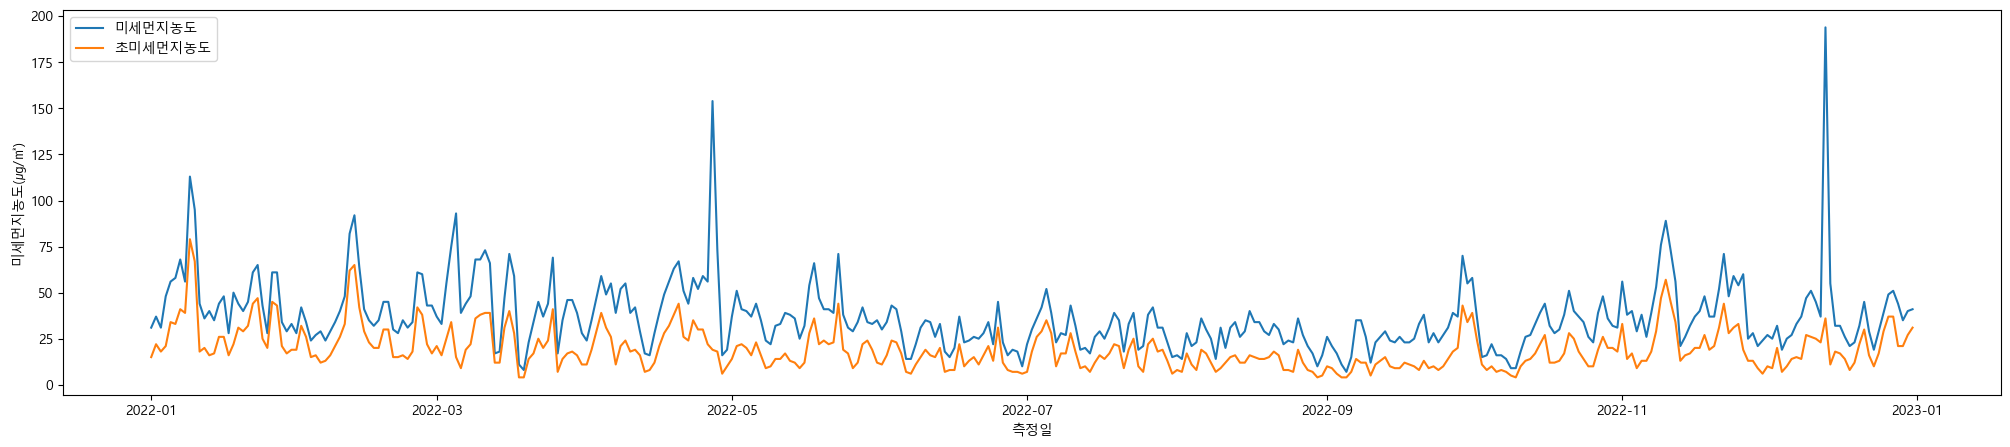

In [25]:
# 미세먼지농도, 초미세먼지농도 시계열 데이터 시각화

plt.figure(figsize=(25,5))
plt.plot(df_filter['측정일'], df_filter['미세먼지농도'], label='미세먼지농도')
plt.plot(df_filter['측정일'], df_filter['초미세먼지농도'], label='초미세먼지농도')
plt.xlabel('측정일')
plt.ylabel('미세먼지농도(㎍/㎥)')
plt.legend(loc='upper left')
plt.show()

### statsmodels

- 주기적인 데이터의 트렌드 추이
- 날짜형 인덱스와 데이터 컬럼
- 결측치 있으면 안됨

In [30]:
df_filter2 = df_filter[['측정일', '미세먼지농도']]
ts = df_filter2.set_index('측정일')
ts.head(3)

,미세먼지농도
측정일,
2022-01-01,31.0
2022-01-02,37.0
2022-01-03,31.0


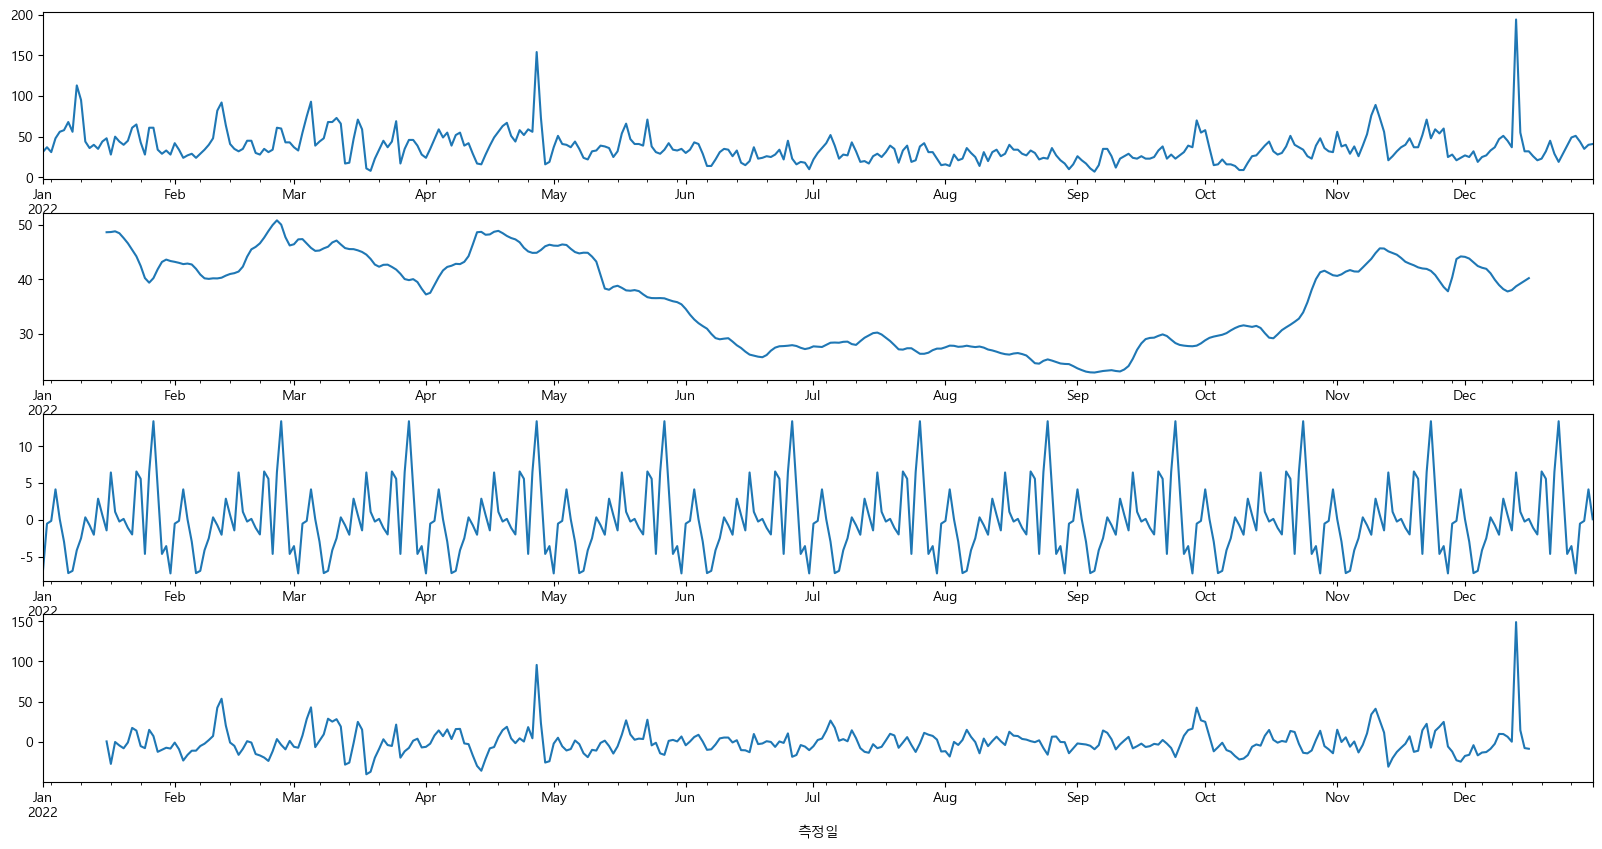

In [39]:
# 시계열 데이터의 구조를 분해하는 도구 : 실제값 추세, 계절성, 잔차를 분석

from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(ts['미세먼지농도'], 
                            period=30) # 30일 단위로 계절성을 분석

# result.observed : 실제 데이터
# result.trend    : 데이터의 장기적인 변화, 전반적으로 감소했는지 증가했는지. 왜 NaN이냐면 30일단위로 보기로 했으니까
# result.seasonal : 주기적인 계절성 패턴
# result.resid    : 잔차(실제값에서 추세와 계절성을 뺀 노이즈)

flg, axes = plt.subplots(4,1, figsize = (20,10))
result.observed.plot(ax=axes[0])
result.trend.plot(ax=axes[1])
result.seasonal.plot(ax=axes[2])
result.resid.plot(ax=axes[3])
plt.show()

### Prophet

- 계절성, 추세, 휴일 효과 등을 자동으로 모델, 예측
- ds(시간), y(시계열성 숫자) 컬럼만 있어야함

In [41]:
df_filter2.columns = ['ds','y'] # fit시 컬럼명 ds, y를 읽음
df_filter2.sample()

,ds,y
2746,2022-02-24,34.0


In [42]:
from prophet import Prophet

# 1. 모델 생성
p_model = Prophet()

# 2. 학습
p_model.fit(df_filter2)

17:48:57 - cmdstanpy - INFO - Chain [1] start processing
17:48:57 - cmdstanpy - INFO - Chain [1] done processing


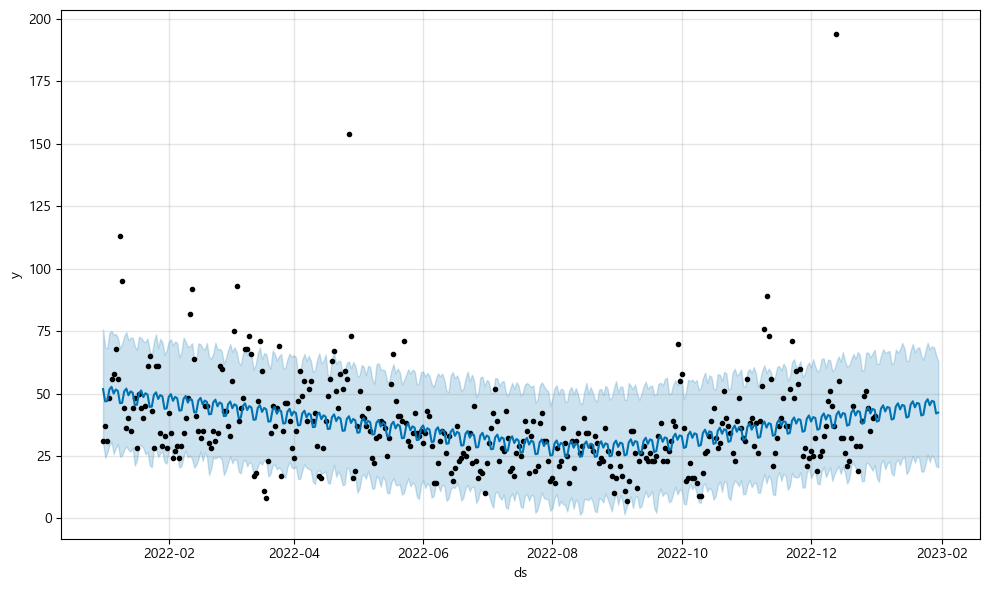

In [47]:
# 3. 30일 이후의 데이터를 예측하는 미래 df을 생성

future = p_model.make_future_dataframe(periods=30)

# 4. 예측 수행
forecast = p_model.predict(future)
# forecast.tail(30)

# 5. 시각화
p = p_model.plot(forecast) # 까만점이 실제값

In [48]:
forecast[['ds', 'yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01,51.770534,30.318320,75.716155
1,2022-01-02,46.824151,24.323984,68.502884
2,2022-01-03,46.973252,26.275277,68.116800
3,2022-01-04,51.610049,29.136241,74.358972
4,2022-01-05,52.693904,30.653369,75.022920
...,...,...,...,...
390,2023-01-26,45.250951,22.581853,67.666496
391,2023-01-27,47.051382,25.198998,68.867427
392,2023-01-28,46.713875,24.027880,68.561946
393,2023-01-29,41.988910,20.883851,65.326645


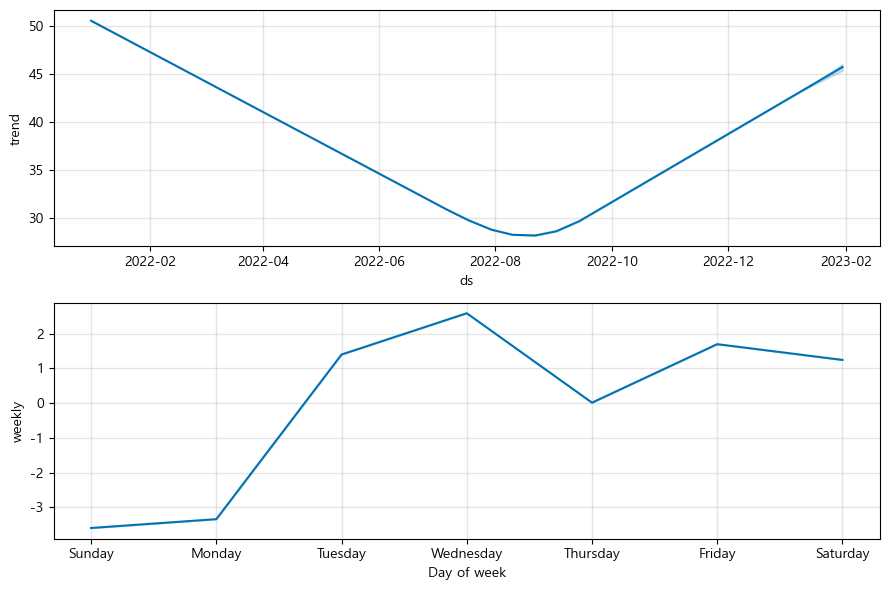

In [49]:
# 트렌드와 휴일 효과

p = p_model.plot_components(forecast)

In [52]:
# 2023-01-12

forecast.loc[forecast['ds']=='2023-01-06', ['ds', 'yhat']]

,ds,yhat
370,2023-01-06,44.613397
